# **Detecting fraudulent transactions with an Artificial Neural Network**

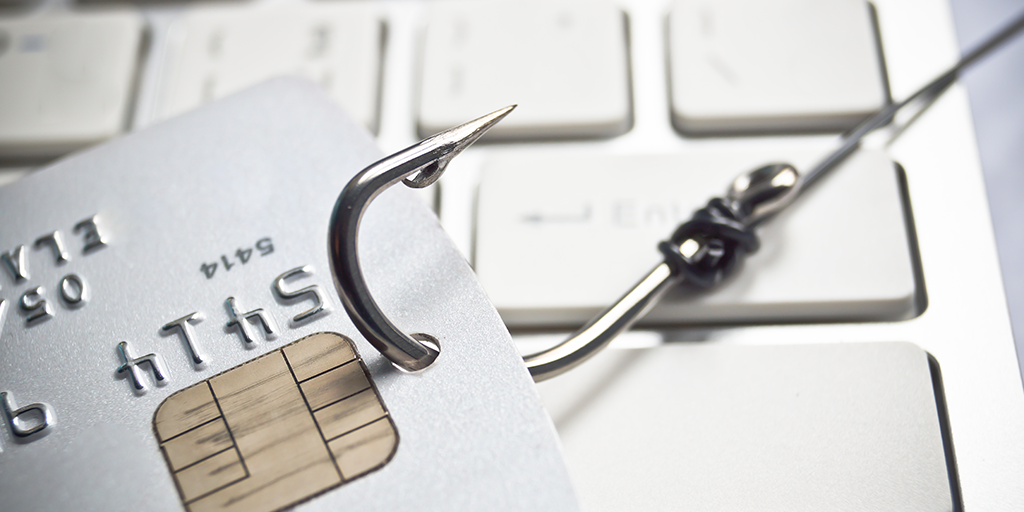

Banking transactions fraud is a serious concern in the financial industry, posing significant risks to both financial institutions and customers. Detecting and preventing fraudulent activities is of utmost importance to maintain trust and secure financial systems.
In this project, we will create an AI model that detects **90.93%** of the actual **fraudulent transactions** and with an **F1-Score = 91.67%**.

# Importing libraries

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

# Data Pre-Proccessing

In [ ]:
df = pd.read_csv("/kaggle/input/fraud-detection-bank-dataset-20k-records-binary/fraud_detection_bank_dataset.csv")

df.shape

In [ ]:
df.head()

In [ ]:
#Drop the first column since it's just the index

df = df.drop('Unnamed: 0', axis = 1)

df.head()

*Let's check the distribution of our features*

In [ ]:

fig, axes = plt.subplots(7, 16, figsize=(30, 15))

# Flatten the axes array to easily iterate over the subplots
axes = axes.flatten()

for col, ax in enumerate(axes):
    sns.kdeplot(data=df, x=f'col_{col}',fill=True, ax=ax,warn_singular=False) 

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(f'col_{col}', loc='center', weight='bold', fontsize=10)
plt.show();


In [ ]:
print("col_14 counts : ",(df['col_14'] > df['col_14'].mean()).sum())
print("col_15 counts : ",(df['col_15'] > df['col_15'].mean()).sum())
print("col_96 counts : ",(df['col_96'] > df['col_96'].mean()).sum())
print("col_97 counts : ",(df['col_97'] > df['col_97'].mean()).sum())
print("col_98 counts : ",(df['col_98'] > df['col_98'].mean()).sum())

It seems that a lot of features are seperated into 2 categories, one with low values and one with high. The high values could possibly be directly connected with the fraudalent clients. So we will not remove outliers to help us detect fraud.

In [ ]:

correlation_matrix = df.drop(['targets'], axis =1).corr()
plt.figure(figsize=(25, 18))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

Columns : 8-12,18-21,35,51-53,70,71 have not any kind of varation and we have to get rid off them

In [ ]:
df_var = df.loc[:,df.nunique()>1] #This way we remove the columns with the same value in every row

correlation_matrix = df_var.drop(['targets'], axis =1).corr().abs()

Now we have to get rid off the highly correlated columns in absolute values. Let's have a threshold of 0.8 

In [ ]:
# Select upper triangular of correlation matrix (excluding diagonal) 
upper = correlation_matrix.where(pd.np.triu(pd.np.ones(correlation_matrix.shape), k=1).astype(bool)) 

# Find index of columns with correlation above threshold
columns_to_drop = [column for column in upper.columns if any(upper[column] >= 0.8)]

# Drop the highly correlated columns
df_filtered = df_var.drop(columns_to_drop, axis=1)

In [ ]:
correlation_matrix = df_filtered.drop(['targets'], axis =1).corr().abs()
plt.figure(figsize=(25, 18))
sns.heatmap(correlation_matrix, annot=False, cmap='Blues', square=True)
plt.title('Correlation Matrix')
plt.show()

Let's now check for null values

In [ ]:
df_filtered.isnull().sum().sum()

# Scaling

We can clearly see that the dataset is imbalanced, so we will procceed by firstly scaling and splitting the data, and then oversampling the training data, so no information of the test data will pass into the training.

In [ ]:
df_filtered.targets.value_counts()


Let's procceed to scaling the data using StandardScaler, because the data are skewed towards 0, a MinMaxScaler would squeeze more the high values than the low values.

In [ ]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_filtered.drop('targets', axis=1))
y = df_filtered['targets']

And continue with splitting the data

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_train.shape


# Oversample

We'll just oversample the training set because in real life the problem is imbalanced by nature and also we don't want to pass any information of the test data to the training of the model.

In [ ]:
#Import and use SMOTE to oversample
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_resampled.shape

In [ ]:
#The training set is currently balanced, and the test set has not information about these objervation
y_train_resampled.value_counts()

# ANN Modeling

We are creating an ANN, to predict whether a transaction is fraudalent or not.

In [ ]:
#Create the model 

from tensorflow.keras.layers import Dense,Dropout,Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

i = Input(shape =(76,) )
x = Dropout(0.2)(i)
x = Dense(64, activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(16, activation = 'relu')(x)
x = Dense(1, activation = 'sigmoid')(x)
model = Model(i,x)

In [ ]:
#Compile the model using precesion to see how many fraudalent movements our model will detect
from tensorflow.keras.metrics import Recall

model.compile(optimizer='adam', loss='binary_crossentropy', metrics= Recall())

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [ ]:
#Fit the model

r = model.fit(X_train_resampled,y_train_resampled, validation_data=(X_test, y_test), callbacks= early_stop, batch_size= 32, epochs = 100)

In [ ]:
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()


plt.plot(r.history['recall_4'], label = 'recall_4')
plt.plot(r.history['val_recall_4'], label = 'val_recall_4')
plt.legend()
plt.show();

# Results

We can see that last **validation recall** is **0.9093** which means that **90.93% of the REAL FRAUDULENT TRANSACTIONS have been "caught" by our model**.

In [ ]:
from sklearn.metrics import confusion_matrix,f1_score
from sklearn import metrics
y_pred = model.predict(X_test)
pred_class =np.where(y_pred < 0.5,0,1)
cm = confusion_matrix(y_test.astype(int), pred_class)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Non-Fraud','Fraud'])
cm_display.plot()
plt.show()

In the confusion matrix we can see that we **falsly labeled only 109 fraudulent transactions as non-fraud**, and only **232 non-fraud transactions as fraud**

In [ ]:
f1_score(y_test.astype(int), pred_class, average = 'micro')

Lastly, f1-score gives us **91.67%** which is very good.